## Garment production productivity prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
workers = pd.read_csv('garments_worker_productivity.csv')
workers.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [3]:
workers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

### EDA

In [4]:
workers.isna().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

The wip column which describes work in progress has lots of np.nan values. This basically does not mean no work in progress because they might have missed that information. Looking at the data at hand, and being that is it the only column with null values i will take the np.nan for work at hand as to mean no work in progress and will be replaced by zeros. 

In [5]:
workers.loc[workers['wip'].isna(), 'wip'] = 0
workers.isna().sum()

date                     0
quarter                  0
department               0
day                      0
team                     0
targeted_productivity    0
smv                      0
wip                      0
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
no_of_workers            0
actual_productivity      0
dtype: int64

In [6]:
sorted(workers.team.unique())

[np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11),
 np.int64(12)]

In [7]:
#updating the actual productivity to 2 dec figures and no of worker to int
workers['actual_productivity'] = workers['actual_productivity'].round(2)

workers['no_of_workers'] = workers['no_of_workers'].astype(int)

In [8]:
workers.department.unique()

array(['sweing', 'finishing ', 'finishing'], dtype=object)

the extra white space for 'finishing ' will be removed as it is an obvious error when the data was inputed but I will see how many roles that is affected. 

In [9]:
dept = workers.loc[workers['department'] == 'finishing ']
dept.shape

(257, 15)

In [10]:
dept.head(3)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,0.0,960,0,0.0,0,0,8,0.89
6,1/1/2015,Quarter1,finishing,Thursday,2,0.75,3.94,0.0,960,0,0.0,0,0,8,0.76
13,1/1/2015,Quarter1,finishing,Thursday,10,0.65,3.94,0.0,960,0,0.0,0,0,8,0.71


In [11]:
workers['department'] = workers['department'].replace({'finishing ': 'finishing'})
workers.department.unique()

array(['sweing', 'finishing'], dtype=object)

In [12]:
workers.loc[workers['department'] == 'finishing'].shape

(506, 15)

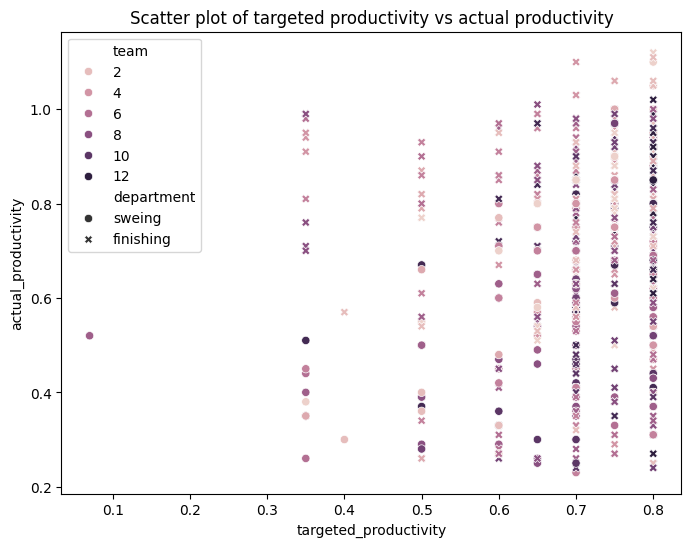

In [13]:
plt.rcParams['figure.figsize'] = [8,6]
sns.scatterplot(data=workers, x='targeted_productivity', y='actual_productivity', 
                style='department', hue='team')
plt.title('Scatter plot of targeted productivity vs actual productivity')
plt.show()

In [14]:
workers['quarter'].value_counts()

quarter
Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: count, dtype: int64

In [15]:
workers['day'].value_counts()

day
Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: count, dtype: int64

In [16]:
workers['department'].value_counts()

department
sweing       691
finishing    506
Name: count, dtype: int64

In [17]:
workers['team'].value_counts()

team
8     109
2     109
4     105
1     105
9     104
10    100
12     99
7      96
3      95
6      94
5      93
11     88
Name: count, dtype: int64

In [18]:
workers['no_of_style_change'].value_counts()

no_of_style_change
0    1050
1     114
2      33
Name: count, dtype: int64

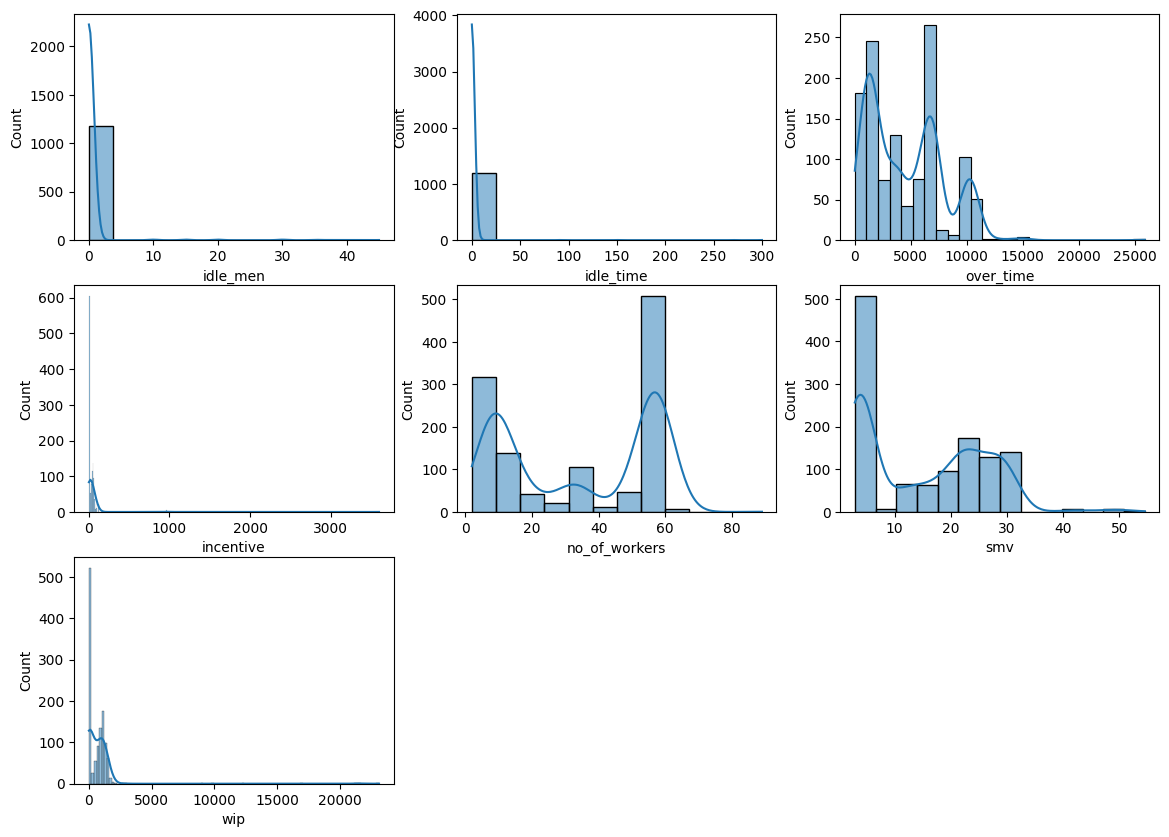

In [19]:
cols = ['idle_men', 'idle_time', 'over_time', 'incentive', 'no_of_workers', 'smv', 'wip']

plt.rcParams['figure.figsize'] = [14, 10]

for idx, item in enumerate(cols):
    ax = plt.subplot(3, 3, idx+1)
    sns.histplot(data=workers, x=item, kde=True, ax=ax)
plt.show()

Friday is not included in the list of days, these may or may not be an error but since i have no further clue on this i will leave the data as it is. Also quarters are listed from quarter 1 to quarter 5. this doesn't seem right and will be investigated 

In [20]:
## investigating the Quarter 5  
quarter_1 = workers.loc[workers['quarter'] == 'Quarter1']
quarter_2 = workers.loc[workers['quarter'] == 'Quarter2']
quarter_3 = workers.loc[workers['quarter'] == 'Quarter3']
quarter_4 = workers.loc[workers['quarter'] == 'Quarter4']
quarter_5 = workers.loc[workers['quarter'] == 'Quarter5']

In [21]:
quarter_1.date.unique()

array(['1/1/2015', '1/3/2015', '1/4/2015', '1/5/2015', '1/6/2015',
       '1/7/2015', '2/1/2015', '2/2/2015', '2/3/2015', '2/4/2015',
       '2/5/2015', '2/7/2015', '3/1/2015', '3/2/2015', '3/3/2015',
       '3/4/2015', '3/5/2015', '3/7/2015'], dtype=object)

In [22]:
quarter_2.date.unique()

array(['1/8/2015', '1/10/2015', '1/11/2015', '1/12/2015', '1/13/2015',
       '1/14/2015', '2/8/2015', '2/9/2015', '2/10/2015', '2/11/2015',
       '2/12/2015', '2/14/2015', '3/8/2015', '3/9/2015', '3/10/2015',
       '3/11/2015'], dtype=object)

In [23]:
quarter_3.date.unique()

array(['1/15/2015', '1/17/2015', '1/18/2015', '1/19/2015', '1/20/2015',
       '1/21/2015', '2/15/2015', '2/16/2015', '2/17/2015', '2/18/2015',
       '2/19/2015'], dtype=object)

In [24]:
quarter_4.date.unique()

array(['1/22/2015', '1/24/2015', '1/25/2015', '1/26/2015', '1/27/2015',
       '1/28/2015', '2/22/2015', '2/23/2015', '2/24/2015', '2/25/2015',
       '2/26/2015', '2/28/2015'], dtype=object)

In [25]:
quarter_5.date.unique()

array(['1/29/2015', '1/31/2015'], dtype=object)

An interesting fact of the date column and quarter column is that the quarters are not distributed according to the year but according to days of the month. Looking at the unique values, you will observe that Quarter1 is from day 1 to day7 of the month, Quarter2 from day 8 to day14, and so on till Quarter5 which is day 29 and day 30.     

Again i will choose to leave this data like this even though the year is divided into 4 quarters, quarters in this case represent days of the month and is unique to this data. 

#### Feature selection
Because I want to use classification in our model, I will transform our target column to categorical variables using the order:     
less than 0.45  = poor    
greater than 0.45 but less than 0.65 = average    
greater than 0.65 but less than 0.85 = high      
greater than 0.85 = very high  

Then columns not neccessary will be dropped and these include: date, day. 

Further modifications to columns will be encoding the categorical columns for modeling. The columns to encode are quarter, department. For ease, the numbers on the quarter columns would be retained and the quarter word left out. 

In [26]:
clean_workers = workers.drop(['date', 'day'], axis=1)

#updating quarter column
clean_workers['quarter'].replace({'Quarter1': 1, 
                                  'Quarter2': 2, 
                                  'Quarter3': 3, 
                                  'Quarter4': 4,
                                  'Quarter5': 5
                                 }, inplace=True)

#updating department column
clean_workers['department'].replace({'sweing':1, 'finishing':0}, inplace=True)
clean_workers.rename(columns={'department':'department_sweing'}, inplace=True)

## updating the actual productivity value
clean_workers['productivity_scale'] = pd.Series()

clean_workers['productivity_scale'].mask(clean_workers['actual_productivity']<=0.45, 'poor', inplace = True)
clean_workers['productivity_scale'].mask((clean_workers['actual_productivity']>0.45) & (clean_workers['actual_productivity']<=0.65), 'average', inplace=True)
clean_workers['productivity_scale'].mask((clean_workers['actual_productivity']>0.65) & (clean_workers['actual_productivity']<=0.85), 'high', inplace=True)
clean_workers['productivity_scale'].mask(clean_workers['actual_productivity']>0.85, 'very high', inplace=True)



C:\Users\austi\AppData\Local\Temp\ipykernel_29228\4227759500.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean_workers['quarter'].replace({'Quarter1': 1,
C:\Users\austi\AppData\Local\Temp\ipykernel_29228\4227759500.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_workers['quarter'].

In [27]:
## transforming the categorical to dummy variables
workers_final = pd.get_dummies(data=clean_workers, columns=['quarter', 'team'], dtype=int)
workers_final.head()

,department_sweing,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12
0,1,0.80,26.16,1108.0,7080,98,0.0,0,0,59,...,0,0,0,0,0,1,0,0,0,0
1,0,0.75,3.94,0.0,960,0,0.0,0,0,8,...,0,0,0,0,0,0,0,0,0,0
2,1,0.80,11.41,968.0,3660,50,0.0,0,0,30,...,0,0,0,0,0,0,0,0,1,0
3,1,0.80,11.41,968.0,3660,50,0.0,0,0,30,...,0,0,0,0,0,0,0,0,0,1
4,1,0.80,25.90,1170.0,1920,50,0.0,0,0,56,...,0,0,0,1,0,0,0,0,0,0


#### Building the model

In [28]:
X = workers_final.drop(['actual_productivity', 'productivity_scale'], axis=1)
y = workers_final['productivity_scale']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24, shuffle=True)


In [29]:
y_train.value_counts(normalize=True).round(4)*100

productivity_scale
high         52.33
very high    20.55
average      17.20
poor          9.92
Name: proportion, dtype: float64

In [30]:
y_test.value_counts(normalize=True).round(4)*100

productivity_scale
high         50.83
very high    25.83
average      15.28
poor          8.06
Name: proportion, dtype: float64

In [31]:
tree_class = DecisionTreeClassifier(criterion='gini',
                                    max_depth = 4, 
                                    random_state= 24)
tree_class.fit(X_train, y_train)
y_pred = tree_class.predict(X_test)

In [32]:
from sklearn.metrics import  classification_report

report  = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

     average       0.65      0.40      0.49        55
        high       0.73      0.85      0.79       183
        poor       0.53      0.31      0.39        29
   very high       0.73      0.74      0.73        93

    accuracy                           0.71       360
   macro avg       0.66      0.58      0.60       360
weighted avg       0.70      0.71      0.70       360



##### Evaluation
The performance of the model is just a little above  average as shown in the classification report for each class and the overall accuracy of 70%. IN the next steps, I will be to try and optimize the model to try and get better performance.

In [33]:
## getting the feature importances of each feature 
tree_class.feature_importances_

array([0.03006762, 0.1573894 , 0.        , 0.02145517, 0.        ,
       0.55348019, 0.01693089, 0.        , 0.        , 0.17947483,
       0.        , 0.        , 0.        , 0.03542255, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00577936, 0.        , 0.        ,
       0.        , 0.        ])

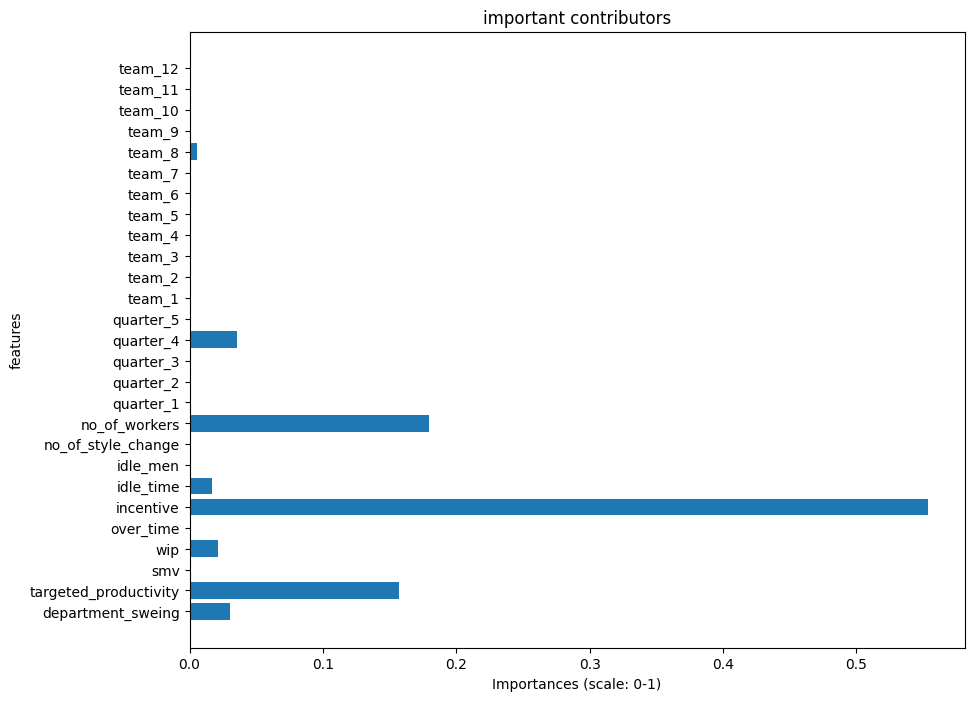

In [34]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.barh(tree_class.feature_names_in_, tree_class.feature_importances_)
plt.xlabel('Importances (scale: 0-1)')
plt.ylabel('features')
plt.title('important contributors')
plt.show()

#### Alpha optimisation
Using alpha optimisation to build the decision tree

In [35]:
class_path = tree_class.cost_complexity_pruning_path(X_train, y_train)
print(class_path.ccp_alphas)

[0.         0.0015598  0.00206298 0.00314878 0.0037276  0.00456952
 0.00811502 0.00843078 0.00956027 0.01503545 0.02561661 0.03025464
 0.06347085 0.08590917]


In [36]:
subtrees = []
for alpha in class_path.ccp_alphas:
    subtree = DecisionTreeClassifier(criterion = 'gini',
                                    max_depth=5,
                                    random_state =24,
                                    ccp_alpha=alpha
                                   )
    subtree.fit(X_train, y_train)
    subtrees.append(subtree)

subtree_scores = [subtree.score(X_test, y_test) for subtree in subtrees]

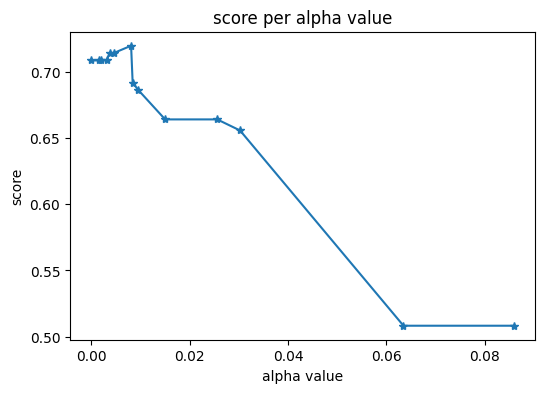

In [37]:
### ploting the scores of alphas 
plt.rcParams['figure.figsize']=[6,4]
plt.plot(class_path.ccp_alphas, subtree_scores, marker='*')
plt.title('score per alpha value')
plt.ylabel('score')
plt.xlabel('alpha value')
plt.show()

In [38]:
# finding the maximum alpha
max(tuple(zip(class_path.ccp_alphas, subtree_scores)), key=lambda x: x[1])

(np.float64(0.008115018556034607), 0.7194444444444444)

In [39]:
max_score = max(tuple(zip(class_path.ccp_alphas, subtree_scores)), key=lambda x: x[1])
opt_alpha = max_score[0]


tree_class_alpha = DecisionTreeClassifier(criterion='gini',
                                          max_depth=5,
                                          random_state=24,
                                          ccp_alpha=opt_alpha)
tree_class_alpha.fit(X_train, y_train)
y_alpha_pred = tree_class_alpha.predict(X_test)

report = classification_report(y_test, y_alpha_pred)
print(report)
                                          

              precision    recall  f1-score   support

     average       0.66      0.42      0.51        55
        high       0.73      0.86      0.79       183
        poor       0.64      0.31      0.42        29
   very high       0.73      0.75      0.74        93

    accuracy                           0.72       360
   macro avg       0.69      0.58      0.61       360
weighted avg       0.71      0.72      0.70       360



The alpha optimisation did  improve the performance by approximatly 1-2% in accuracy and f1_score . I will therefore try the gridsearch to see if there is more improvement   
#### Gridsearch optimisation with cross validation

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

parameters = {'criterion':['gini', 'entropy'],
              'max_depth':list(range(2,10)),
              'min_samples_split':[2, 10, 18, 30],
              'min_samples_leaf':list(range(3,18,2)),
              'class_weight':[None,'balanced']
             }
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=24),
                           param_grid=parameters, 
                           scoring=make_scorer(accuracy_score),
                           n_jobs=-1
                          )
grid_search.fit(X, y)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=24), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [3, 5, 7, 9, 11, 13, 15, 17],
                         'min_samples_split': [2, 10, 18, 30]},
             scoring=make_scorer(accuracy_score, response_method='predict'))

In [41]:
print(grid_search.best_score_)

0.6457182705718271


In [42]:
print(grid_search.best_estimator_)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=15,
                       random_state=24)


In [43]:
print(grid_search.best_params_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 15, 'min_samples_split': 2}


##### Fitting the model with the parameters

In [44]:
dt_class = DecisionTreeClassifier(criterion ='entropy',
                                  max_depth=3,
                                  min_samples_leaf=15,
                                  min_samples_split=2,
                                  random_state=24)
dt_class.fit(X_train, y_train)
y_pred_opti = dt_class.predict(X_test)

report = classification_report(y_test, y_pred_opti)
print(report)

              precision    recall  f1-score   support

     average       0.59      0.42      0.49        55
        high       0.71      0.87      0.78       183
        poor       0.00      0.00      0.00        29
   very high       0.73      0.75      0.74        93

    accuracy                           0.70       360
   macro avg       0.51      0.51      0.50       360
weighted avg       0.64      0.70      0.66       360



C:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

The grid search parameters did not perform better than the ccp_alpha optimisation unfortunately, rather was only slightly lower in accuracy.  

__`Therefore I will accept the alpha class optimised decision tree for my model at the moment`__. 

#### Visualising the optimised alpha decision tree

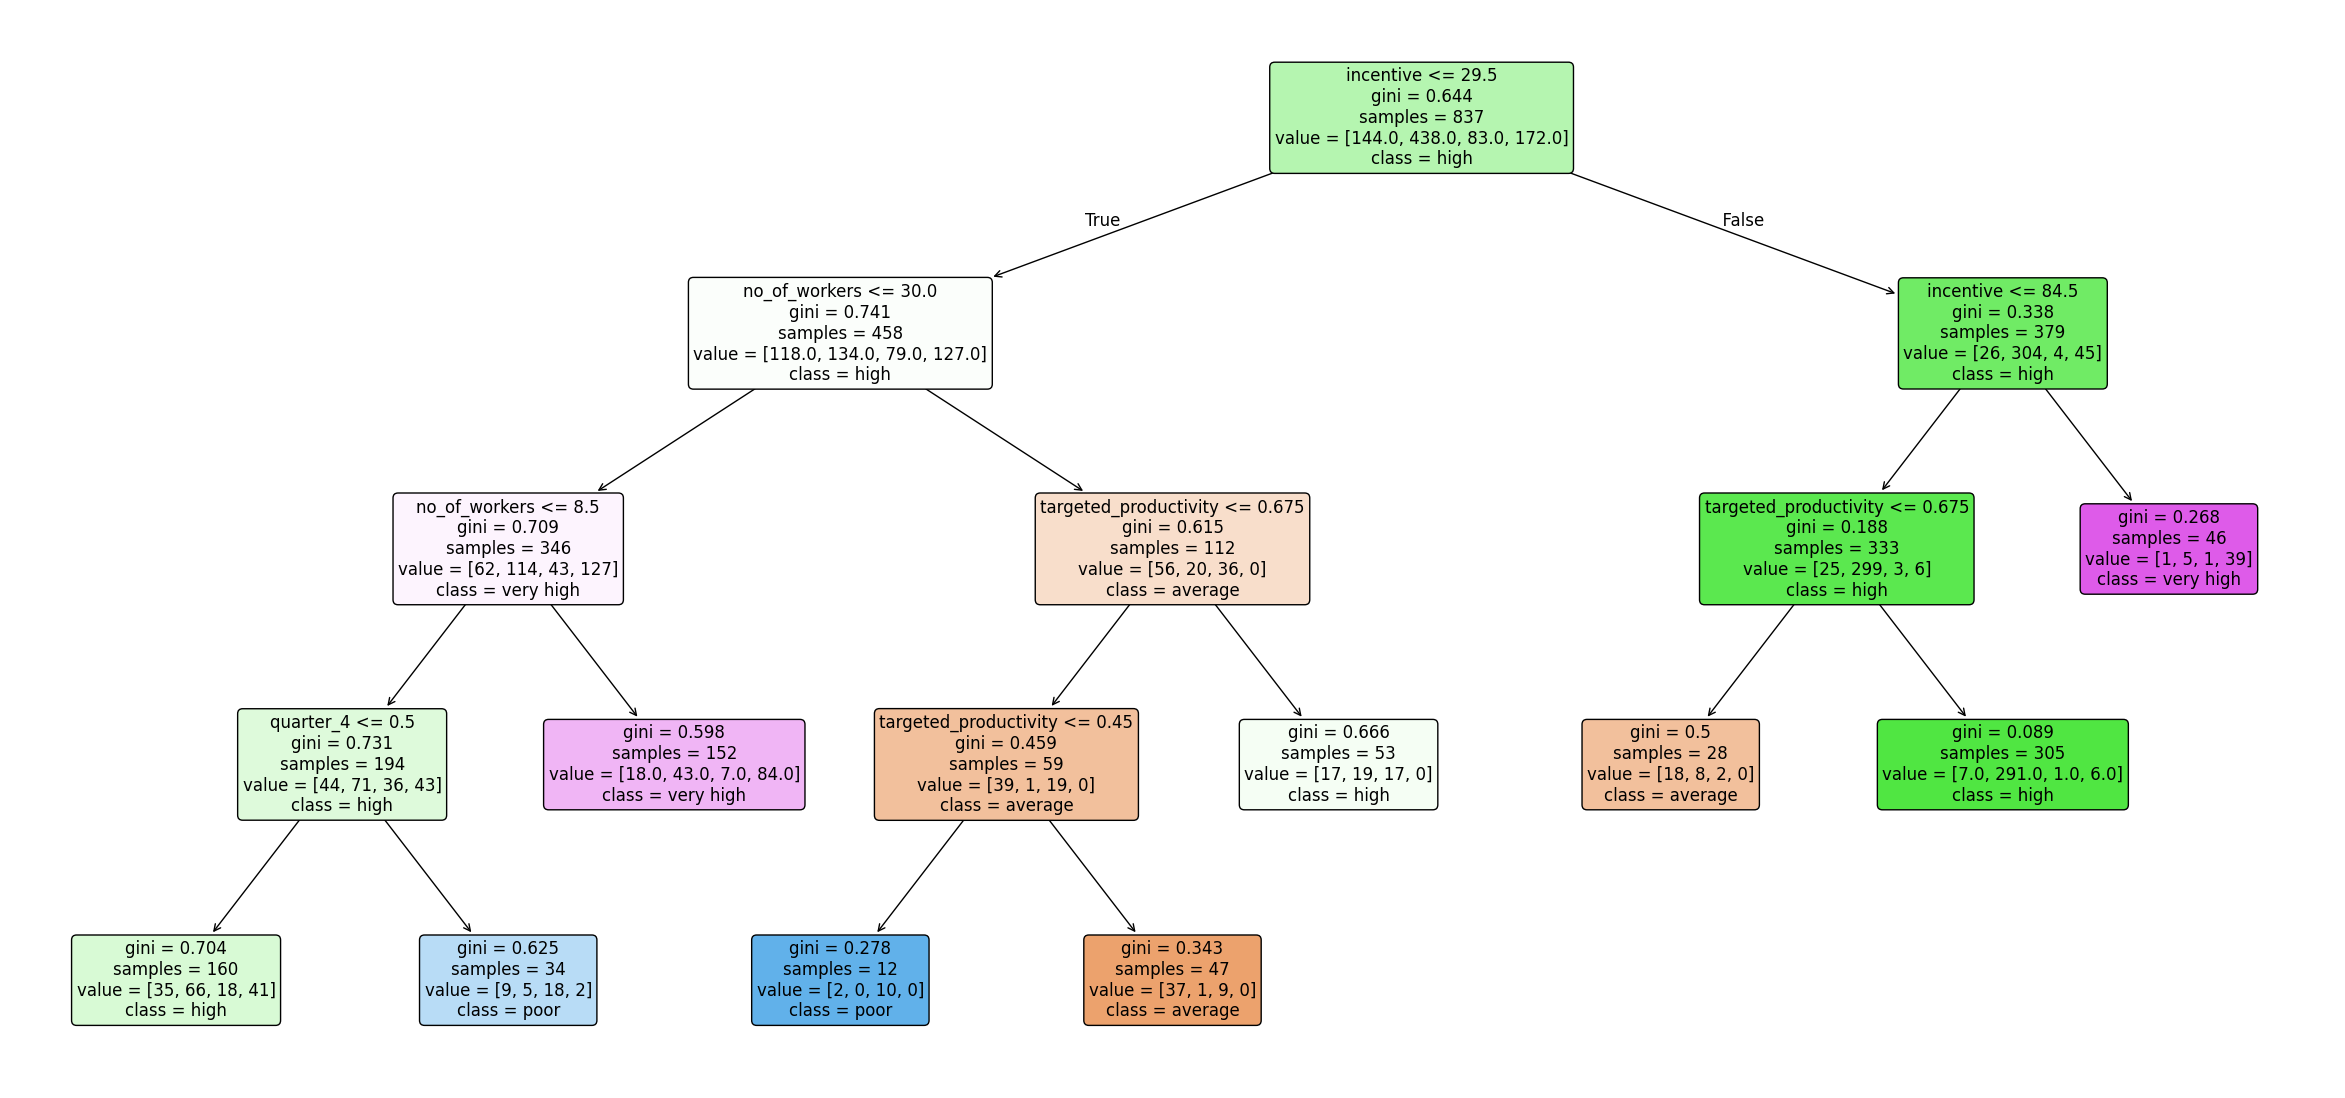

In [45]:
from sklearn.tree import plot_tree

plt.figure(figsize=(30, 14))
_ = plot_tree(tree_class_alpha,
              class_names = tree_class_alpha.classes_,
              feature_names = X.columns,
              filled=True,
              precision=3,
              proportion=False,
              rounded=True,
              fontsize=12
             )

plt.show()

#### Summary 
Incentives and no_of_workers (number of workers) are the biggest determinants of productivity in the decision tree, this is followed up closely by the targeted_productivity column as seen in the internal node of the tree.   

For example, with an incentive of 50.5 and targetd productivity of 0.72, the root of the tree evaluates to false and we go down the right hand of the tree. We evaluate the incentive again which is < 84.5, then targeted_productivity becomes the next lever of influence. When we evaluate our targeted productivity of 0.72, we see that this is not <= 0.68 which results in false. Therefore our predicted outcome will be high.  

On the left hand of the tree from the tree root, we can see that when incentive is <=29.5, then the no_of_workers (number of workers) becomes the next evaluator and this same principles apply.


### Cross validation of model


In [46]:
from sklearn.model_selection import cross_validate 

clf_cross_val = cross_validate(tree_class_alpha, X, y, cv=7,
                               n_jobs = -1, 
                               scoring=('accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'recall_weighted')
                              )
clf_cross_val

{'fit_time': array([0.00661373, 0.00759363, 0.0065558 , 0.00753713, 0.00701499,
        0.00798321, 0.00700331]),
 'score_time': array([0.01702571, 0.0190239 , 0.01703238, 0.01605105, 0.01905179,
        0.01705837, 0.01604581]),
 'test_accuracy': array([0.65497076, 0.70760234, 0.71345029, 0.65497076, 0.5497076 ,
        0.67836257, 0.70175439]),
 'test_precision_macro': array([0.50717395, 0.51995001, 0.59499032, 0.65410079, 0.40795097,
        0.73400424, 0.80974182]),
 'test_recall_macro': array([0.43612191, 0.51462047, 0.58510787, 0.53581857, 0.47505568,
        0.49288742, 0.56064359]),
 'test_f1_macro': array([0.4420547 , 0.51036261, 0.57938667, 0.54375928, 0.41286472,
        0.49062083, 0.57265785]),
 'test_recall_weighted': array([0.65497076, 0.70760234, 0.71345029, 0.65497076, 0.5497076 ,
        0.67836257, 0.70175439])}

In [47]:
print(f"Mean test_accuracy: {clf_cross_val['test_accuracy'].mean().round(2)}")
print(f"Mean test_precision: {clf_cross_val['test_precision_macro'].mean().round(2)}")
print(f"Mean test_recall: {clf_cross_val['test_recall_macro'].mean().round(2)}")
print(f"Mean test_f1_macro: {clf_cross_val['test_f1_macro'].mean().round(2)}")
print(f"Mean test_recall_weighted: {clf_cross_val['test_recall_weighted'].mean().round(2)}")

Mean test_accuracy: 0.67
Mean test_precision: 0.6
Mean test_recall: 0.51
Mean test_f1_macro: 0.51
Mean test_recall_weighted: 0.67


Cross validation data shows that our model is stable across folds and is reasonably a good result. It also shows that there is room for improvements still in the model. 

#### Modelling with random forest

In [48]:
from sklearn.ensemble import RandomForestClassifier


random_forest = RandomForestClassifier(
                            oob_score=True,
                             n_jobs=-1,
                             random_state=24,
                            )
random_forest.fit(X_train, y_train)
random_forest_pred = random_forest.predict(X_test)
random_forest_accuracy = round(accuracy_score(y_test, random_forest_pred),3)
print(random_forest_accuracy)

0.733


In [49]:
random_forest_report = classification_report(y_test, random_forest_pred)
print(random_forest_report)

              precision    recall  f1-score   support

     average       0.50      0.49      0.50        55
        high       0.83      0.79      0.81       183
        poor       0.50      0.45      0.47        29
   very high       0.75      0.85      0.80        93

    accuracy                           0.73       360
   macro avg       0.65      0.65      0.64       360
weighted avg       0.73      0.73      0.73       360



## Final thoughts
The performance of random forests shows some little improvement in the data but not a massive jump. It however shows the model performance from the decision trees with an optimal alpha was stable enough as was seen also from the cross validation results. There is still room for optimisations in the model but for the purposes of this exercise, the model has performed well enough.